# A base de dados

### Carregando o dataset

In [ ]:
from google.colab import files
files.upload()

In [1]:
import pandas as pd

dados = pd.read_csv('Bicicletas.csv')

### Conhecendo a base de dados

In [2]:
dados.head()

,clima,temperatura,bicicletas_alugadas
0,2,0.363625,985
1,2,0.353739,801
2,1,0.189405,1349
3,1,0.212122,1562
4,1,0.229270,1600


In [3]:
dados.shape

(731, 3)

In [4]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'temperatura')

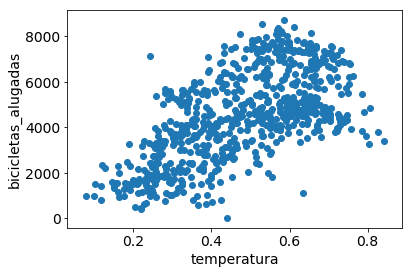

In [5]:
plt.rcParams.update({'font.size': 14})
plt.scatter(dados['temperatura'],dados['bicicletas_alugadas'])
plt.ylabel('bicicletas_alugadas')
plt.xlabel('temperatura')

([<matplotlib.axis.XTick at 0x7facc6170a58>,
 <a list of 3 Text xticklabel objects>)

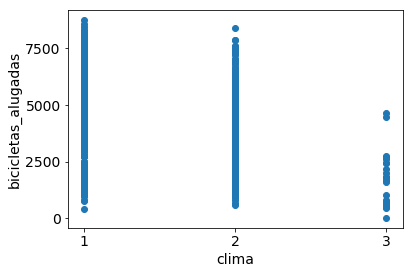

In [7]:
plt.scatter(dados['clima'],dados['bicicletas_alugadas'])
plt.ylabel('bicicletas_alugadas')
plt.xlabel('clima')
plt.rcParams.update({'font.size': 22})
indice=[1,2,3]
plt.xticks(indice, fontsize=14)

### Normalizando a base de dados

In [8]:
import numpy as np

In [9]:
y = dados['bicicletas_alugadas'].values

In [10]:
X = dados[['clima','temperatura']].values
print(X)

[[2.       0.363625]
 [2.       0.353739]
 [1.       0.189405]
 ...
 [2.       0.2424  ]
 [1.       0.2317  ]
 [2.       0.223487]]


In [11]:
X = X/np.amax(X,axis=0)
print(X)

[[0.66666667 0.43242565]
 [0.66666667 0.42066914]
 [0.33333333 0.22524188]
 ...
 [0.66666667 0.28826395]
 [0.33333333 0.27553942]
 [0.66666667 0.26577246]]


In [12]:
ymax=np.amax(y)
y = y/ymax
print(y[0:10])

[0.11303649 0.09192105 0.15480835 0.17925178 0.18361258 0.18430112
 0.17328437 0.11005279 0.09433096 0.15159513]


### Funções de ativação

In [13]:
def sigmoid(Soma):
    return 1/(1+np.exp(-Soma))

def relu(Soma):
    return np.maximum(0,Soma)

### Criando a estrutura da rede

In [14]:
arquitetura = [
    {"dim_entrada": 2, "dim_saida": 50, "ativacao": "relu"},
    {"dim_entrada": 50, "dim_saida": 1, "ativacao": "sigmoid"},
]

### Pesos e viés

In [15]:
def inicia_camadas(arquitetura, seed = 99):
    # inicia os valores aleatórios
    np.random.seed(seed)
    # numero de camadas da rede neural
    numero_de_camadas = len(arquitetura)
    # inicia armazenamento de parametros
    valores_parametros = {}
    
    # itera nas camadas da rede
    for indice, camada in enumerate(arquitetura):
        
        indice_camada = indice + 1
        
        # extrai o numero de nodos nas camadas
        tamanho_camada_entrada = camada["dim_entrada"]
        tamanho_camada_saida = camada["dim_saida"]
        
        # inicia os valores na matriz de pesos P
        # e o vetor de viés ou bias b
        valores_parametros['P' + str(indice_camada)] = np.random.randn(
            tamanho_camada_saida, tamanho_camada_entrada)  * 0.1
        valores_parametros['b' + str(indice_camada)] = np.random.randn(
            tamanho_camada_saida, 1) * 0.1
        
    return valores_parametros

### Propagação da rede

In [16]:
def propaga_uma_camada(Ativado_anterior, Pesos_atual, b_atual, ativacao="relu"):
    # cálculo da entrada para a função de ativação
    Saida_atual = np.dot(Pesos_atual, Ativado_anterior) + b_atual
    
    # selecção da função de ativação
    if ativacao is "relu":
        func_ativacao = relu
    elif ativacao is "sigmoid":
        func_ativacao = sigmoid
    else:
        raise Exception('Ainda não implementamos essa funcao')
        
    # retorna a ativação calculada Ativado_atual e a matriz intermediária Saida
    return func_ativacao(Saida_atual), Saida_atual

In [17]:
def propaga_total(X, valores_parametros, arquitetura):
    # memoria temporaria para a retropropagacao
    memoria = {}
    # O vetor X é a ativação para a camada 0 
    Ativado_atual = X
    
    # iterações para as camadas
    for indice, camada in enumerate(arquitetura):
        # a numeração das camadas começa de 1
        indice_camada = indice + 1
        # utiliza a ativação da iteração anterior
        Ativado_anterior = Ativado_atual
        
        # extrai a função de ativação para a camada atual
        func_ativacao_atual = camada["ativacao"]
        # extrai os pesos da camada atual
        Pesos_atual = valores_parametros["P" + str(indice_camada)]
        # extrai o bias para a camada atual
        b_atual = valores_parametros["b" + str(indice_camada)]
        # cálculo da ativação para a camada atual
        Ativado_atual, Saida_atual = propaga_uma_camada(Ativado_anterior, Pesos_atual, b_atual, func_ativacao_atual)
        
        # salca os valores calculados na memória
        memoria["A" + str(indice)] = Ativado_anterior
        memoria["Z" + str(indice_camada)] = Saida_atual
       
    # retorna o vetor predito e um dicionário contendo os valores intermediários
    return Ativado_atual, memoria

### Testando a rede

In [18]:
valores_parametros = inicia_camadas(arquitetura, seed = 99)
y_estimado, memoria = propaga_total(np.transpose(X), valores_parametros, arquitetura)

In [19]:
y_estimado[0,0]*ymax

4579.982967258466

In [20]:
y[0]*ymax

985.0000000000001

### Atualização dos pesos

In [21]:
def atualiza(valores_parametros, gradidentes, arquitetura, taxa_aprendizagem):

    # iterações pelas camadas
    for indice_camada, camada in enumerate(arquitetura, 1):
        valores_parametros["P" + str(indice_camada)] -= taxa_aprendizagem * gradidentes["dP" + str(indice_camada)]        
        valores_parametros["b" + str(indice_camada)] -= taxa_aprendizagem * gradidentes["db" + str(indice_camada)]

    return valores_parametros;

### Função de custo

In [22]:
def valor_de_custo(Y_predito, Y):
    # numero_de_exemplos
    m = Y_predito.shape[1]
    
    custo = -1 / m * (np.dot(Y, np.log(Y_predito).T) + np.dot(1 - Y, np.log(1 - Y_predito).T))
    return np.squeeze(custo)

### Retropropagação

In [23]:
def retropropagacao_total(Y_predito, Y, memoria, valores_parametros, arquitetura):
   
    gradientes = {}
    
    # numero de exemplos
    #m = Y.shape[1]
    # para garantir que os dois vetores tenham a mesma dimensão
    Y = Y.reshape(Y_predito.shape)
    
    # inicia o algoritmo de gradiente descendente
    dAtivado_anterior = - (np.divide(Y, Y_predito) - np.divide(1 - Y, 1 - Y_predito));
    
    for indice_camada_anterior, camada in reversed(list(enumerate(arquitetura))):
        
        indice_camada_atual = indice_camada_anterior + 1
        # Função de ativação para a camada atual
        
        funcao_ativao_atual = camada["ativacao"]
        
        dAtivado_atual = dAtivado_anterior
        
        Ativado_anterior = memoria["A" + str(indice_camada_anterior)]
        Saida_atual = memoria["Z" + str(indice_camada_atual)]
        
        Pesos_atual = valores_parametros["P" + str(indice_camada_atual)]
        b_atual = valores_parametros["b" + str(indice_camada_atual)]
        
        dAtivado_anterior, dPesos_atual, db_atual = retropropagacao_uma_camada(
            dAtivado_atual, Pesos_atual, b_atual, Saida_atual, Ativado_anterior, funcao_ativao_atual)
        
        gradientes["dP" + str(indice_camada_atual)] = dPesos_atual
        gradientes["db" + str(indice_camada_atual)] = db_atual
    
    return gradientes

In [24]:
def sigmoid_retro(dAtivado, Saida):
    sig = sigmoid(Saida)
    return dAtivado * sig * (1 - sig)

def relu_retro(dAtivado, Saida):
    dSaida = np.array(dAtivado, copy = True)
    dSaida[Saida <= 0] = 0;
    return dSaida;

In [25]:
def retropropagacao_uma_camada(dAtivado_atual, Pesos_atual, b_atual, Saida_atual, Ativado_anterior, ativacao="relu"):
    # número de exemplos
    m = Ativado_anterior.shape[1]
    
    # seleção função de ativação
    if ativacao is "relu":
        func_ativacao_retro = relu_retro
    elif ativacao is "sigmoid":
        func_ativacao_retro = sigmoid_retro
    else:
        raise Exception('Ainda não implementamos essa funcao')
    
    # derivada da função de ativação
    dSaida_atual = func_ativacao_retro(dAtivado_atual, Saida_atual)
    
    # derivada da matriz de Pesos
    dPesos_atual = np.dot(dSaida_atual, Ativado_anterior.T) / m
    # derivada do vetor b
    db_atual = np.sum(dSaida_atual, axis=1, keepdims=True) / m
    # derivada da matriz A_anterior
    dAtivado_anterior = np.dot(Pesos_atual.T, dSaida_atual)

    return dAtivado_anterior, dPesos_atual, db_atual

### Treinamento

In [26]:
def treino(X, Y,X_teste,Y_teste, arquitetura, epocas, taxa_aprendizagem):
    # Inicia os parâmetros da rede neural
    valores_parametros = inicia_camadas(arquitetura, 2)
    # Listas que vão guardar o progresso da aprendizagem da rede 
    historia_custo = []
    historia_custo_teste = []
   
    
    # Atualiza a cada época
    for i in range(epocas):
        # Propaga a rede - Foward propagation
        Y_predito, memoria = propaga_total(X, valores_parametros, arquitetura)
        
        Y_predito_teste, memoria2 = propaga_total(X_teste, valores_parametros, 
                                                  arquitetura)
        
        # calcula as métricas e salva nas listas de história
        custo = valor_de_custo(Y_predito, Y)
        historia_custo.append(custo)
        custo_teste = valor_de_custo(Y_predito_teste, Y_teste)
        historia_custo_teste.append(custo_teste)
        
        
        # Retropropagação - Backpropagation
        gradientes = retropropagacao_total(Y_predito, Y, memoria, 
                                           valores_parametros, arquitetura)
        # Atualiza os pesos
        valores_parametros = atualiza(valores_parametros, gradientes, 
                                      arquitetura, taxa_aprendizagem)
        
        if(i % 50 == 0):
            
            print("Iteração: {:05} - custo: {:.5f} ".format(i, custo))
            
            
    return valores_parametros, historia_custo, historia_custo_teste

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_treino, X_teste, y_treino, y_teste = train_test_split( X, y, test_size=0.43, random_state=42)

In [29]:
# Treinamento
valores_parametros, historia_custo, historia_custo_teste = treino(np.transpose(X_treino), np.transpose(y_treino.reshape((y_treino.shape[0], 1))), 
                                                                  np.transpose(X_teste), np.transpose(y_teste.reshape((y_teste.shape[0], 1))), 
                                                                  arquitetura, 20000, 0.01)

Iteração: 00000 - custo: 0.69396 
Iteração: 00050 - custo: 0.69246 
Iteração: 00100 - custo: 0.69136 
Iteração: 00150 - custo: 0.69054 
Iteração: 00200 - custo: 0.68991 
Iteração: 00250 - custo: 0.68939 
Iteração: 00300 - custo: 0.68894 
Iteração: 00350 - custo: 0.68852 
Iteração: 00400 - custo: 0.68812 
Iteração: 00450 - custo: 0.68773 
Iteração: 00500 - custo: 0.68735 
Iteração: 00550 - custo: 0.68700 
Iteração: 00600 - custo: 0.68667 
Iteração: 00650 - custo: 0.68635 
Iteração: 00700 - custo: 0.68605 
Iteração: 00750 - custo: 0.68575 
Iteração: 00800 - custo: 0.68545 
Iteração: 00850 - custo: 0.68515 
Iteração: 00900 - custo: 0.68485 
Iteração: 00950 - custo: 0.68455 
Iteração: 01000 - custo: 0.68424 
Iteração: 01050 - custo: 0.68394 
Iteração: 01100 - custo: 0.68363 
Iteração: 01150 - custo: 0.68333 
Iteração: 01200 - custo: 0.68302 
Iteração: 01250 - custo: 0.68271 
Iteração: 01300 - custo: 0.68239 
Iteração: 01350 - custo: 0.68208 
Iteração: 01400 - custo: 0.68176 
Iteração: 0145

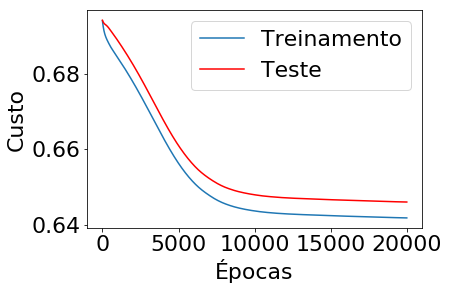

In [30]:
plt.plot(historia_custo)
plt.plot(historia_custo_teste, 'r')
plt.legend(['Treinamento','Teste'])
plt.ylabel('Custo')
plt.xlabel('Épocas')
plt.show()

### Fazendo Previsões

In [31]:
# Previsão
Y_pred, _ = propaga_total(np.transpose(X_teste), valores_parametros, arquitetura)

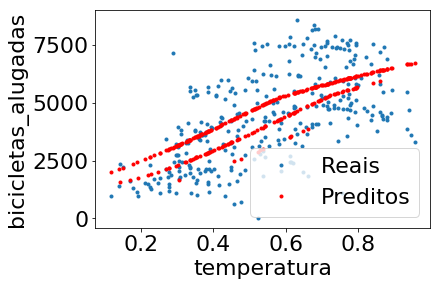

In [32]:
plt.plot(np.transpose(X_teste)[1],ymax*y_teste,'.')
plt.plot(np.transpose(X_teste)[1],ymax*Y_pred.reshape([-1,1]),'.r')
plt.legend(['Reais','Preditos'])
plt.ylabel('bicicletas_alugadas')
plt.xlabel('temperatura')
plt.show()

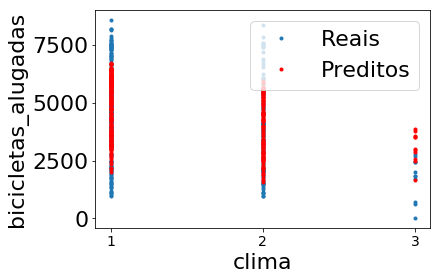

In [33]:
plt.plot(3*np.transpose(X_teste)[0],ymax*y_teste,'.')
plt.plot(3*np.transpose(X_teste)[0],ymax*Y_pred.reshape([-1,1]),'.r')
plt.legend(['Reais','Preditos'])
plt.ylabel('bicicletas_alugadas')
plt.xlabel('clima')
plt.rcParams.update({'font.size': 22})
indice=[1,2,3]
plt.xticks(indice, fontsize=14)
plt.show()